# State Reconstruction after two-qubit channel application

In [1]:
import numpy as np
import scipy as sp
import scipy.linalg
import matplotlib.pyplot as plt
import qiskit as qk
import qiskit.visualization

from qiskit import Aer
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector

from qiskit.providers.aer import AerSimulator
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit import transpile
from qiskit.quantum_info.operators import Operator


import tensorflow as tf
print("TensorFlow version:", tf.__version__)
from tensorflow.python.framework.ops import convert_to_tensor

tf.debugging.set_log_device_placement(False)

TensorFlow version: 2.11.0


In [2]:
#Ensure reproducibility
np.random.seed(123)
tf.random.set_seed(123)
import random
random.seed(10)

## Data Generation

In [3]:
# Generation of a random unitary transformation
def random_unitary(N):
    Z=np.random.randn(N,N) + 1.0j * np.random.randn(N,N)
    [Q,R]=sp.linalg.qr(Z)
    D=np.diag(np.diagonal(R)/np.abs(np.diagonal(R)))
    return np.dot(Q,D)

In [4]:
#Function which generates the density matrix given the state vector
def get_density_matrix(state_vector):
    density_matrix = np.outer(state_vector, np.conjugate(state_vector))
    return density_matrix

In [5]:
#Choice of the simulator
sim_bknd=Aer.get_backend('aer_simulator')

In [6]:
def generate_Haar_data(num_qubits, samples=1000):
    data = []
    for i in range(samples):
        qc = qk.QuantumCircuit(num_qubits) #creates a quantum circuit with "num_qubits" qubits
        u = random_unitary(2**num_qubits)
        qc.unitary(u, qubits=range(num_qubits)) #applies the random unitary transformation to the circuit
        qc = qk.transpile(qc, backend=sim_bknd) #it's used to optimize the circuit
        qc.save_statevector() #it's the instruction to save the state vector obtained by the simulation

        state = sim_bknd.run(qc).result().get_statevector(qc) #does the simulation and gets the state vector
        state = np.asarray(state)
        data.append(state) 
    return data

## Useful Functions

In [7]:
#function which returns bloch components from density matrix
def bloch_coeffs(rho):
    c = []
    for p in pauli_basis2q_modified:
        c.append(np.trace(rho @ p))
    return np.array(c)

In [8]:
#function which returns density matrix from bloch components
def rho_from_coeffs(coeffs):
    rho = 0.25 * np.sum([c * p for c,p in zip(coeffs, pauli_basis2q)], axis=0)
    return rho

In [9]:
I_4 = tf.constant([[1.0, 0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0]],shape=(4,4), dtype = tf.complex64)
I = np.array([[1, 0],[0, 1]])
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])
pauli_basis1q = np.array([I, X, Y, Z])
pauli_basis2q = np.array([np.kron(a,b) for a in pauli_basis1q for b in pauli_basis1q])
pauli_basis2q_modified = pauli_basis2q[1:]


def fid_twoq(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk', pauli_basis2q_modified, a)
   el_b = tf.einsum('ijk,mi->mjk', pauli_basis2q_modified, b)
   rho_a = 0.25 *(el_a + I_4)
   rho_b = 0.25 * (el_b +I_4)
   fidelity = tf.linalg.trace(tf.linalg.sqrtm(tf.linalg.sqrtm(rho_a) @ rho_b @ tf.linalg.sqrtm(rho_a))) **2
   return fidelity 

In [10]:
@tf.function
def infidelity(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk',pauli_basis2q_modified,a) 
   el_b = tf.einsum('ijk,mi->mjk',pauli_basis2q_modified,b) 
   rho_a = 0.25 *(el_a + I_4)
   rho_b = 0.25 * (el_b +I_4)
   fidelity = tf.linalg.trace(tf.linalg.sqrtm(tf.linalg.sqrtm(rho_a) @ rho_b @ tf.linalg.sqrtm(rho_a))) 
   infidelity = 1 - fidelity
   infidelity = tf.cast(infidelity, dtype = tf.float32)
   return infidelity 

In [11]:
@tf.function
def inf(a,b):
   a = tf.cast(a, tf.complex64)
   b = tf.cast(b, tf.complex64)
   el_a = tf.einsum('ijk,mi->mjk',pauli_basis2q_modified,a) 
   el_b = tf.einsum('ijk,mi->mjk',pauli_basis2q_modified,b) 
   rho_a = 0.25 *(el_a + I_4)
   rho_b = 0.25 * (el_b +I_4)
   fidelity = tf.linalg.trace(rho_a @ rho_b)
   infidelity = 1 - fidelity
   infidelity = tf.cast(infidelity, dtype = tf.float32)
   return infidelity 

## Noise Model 

In [12]:
#SINGLE ELEMENT OF THE OPERATOR-SUM REPRESENTATION

def sum_element(rho,operator):
    element = np.dot(np.dot(operator,rho),operator.conj().T)
    return element

In [13]:
#CORRELATED TWO-QUBIT AMPLITUDE DAMPING CHANNEL

def corr_twoq_ad(num_qubits, rho, eta, mu):
    
    E_0 = np.array([[1, 0], [0, np.sqrt(eta)]])
    E_1 = np.array([[0, np.sqrt(1 - eta)], [0, 0]])
    
    A_0 = np.kron(E_0, E_0)
    A_1 = np.kron(E_0, E_1)
    A_2 = np.kron(E_1, E_0)
    A_3 = np.kron(E_1, E_1)


    B_0 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, np.sqrt(eta)]])
    B_1 = np.array([[0, 0, 0, np.sqrt(1 - eta)], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0]])

    N_0 = sum_element(rho, A_0) + sum_element(rho, A_1) + sum_element(rho, A_2) + sum_element(rho, A_3)
    N_1 = sum_element(rho, B_0) + sum_element(rho, B_1)

    noisy_rho = (1 - mu) * N_0 + mu * N_1
    return noisy_rho

## Training the Algorithm

In [14]:
data = generate_Haar_data(2, 1000) 
density_matrix_noise_free = [*map(get_density_matrix, data)] 
bloch_vectors_noise_free = [*map(bloch_coeffs, density_matrix_noise_free)]

In [15]:
#APPLY ERROR 
density_matrix_with_noise = []
for i in range(len(data)):
    single_data_with_noise = corr_twoq_ad(2, density_matrix_noise_free[i], 0.2, 0.3)
    density_matrix_with_noise.append(single_data_with_noise)

#PRINT THE TYPE OF THE SINGLE DENSITY MATRIX IN THE LISTS OF THE DENSITY MATRICES WITH NOISE
print("Density matrix with noise type:", density_matrix_with_noise[0].dtype)

#COMPUTE_BLOCH VECTOR WITH NOISE
bloch_vectors_with_noise = [*map(bloch_coeffs, density_matrix_with_noise)]
print("Bloch vector with noise type:", bloch_vectors_with_noise[0].dtype)

Density matrix with noise type: complex128
Bloch vector with noise type: complex128


## <font color='red'>MSE</font>

In [16]:
x_train_list = bloch_vectors_with_noise[:300]
y_train_list = bloch_vectors_noise_free[:300]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = bloch_vectors_with_noise[500:800]
y_val_list = bloch_vectors_noise_free[500:800]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = bloch_vectors_with_noise[800:]
y_test_list = bloch_vectors_noise_free[800:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [17]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),                                 
  #tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'), 
  tf.keras.layers.Dense(15)
  ])

In [18]:
# Define Loss
loss_fn = tf.keras.losses.mse
# Compile model
adam_opt = tf.optimizers.Adam(0.001)
model.compile(optimizer=adam_opt,
              loss=loss_fn)

In [19]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=50, epochs=600)

Epoch 1/600
6/6 [==============================] - 2s 72ms/step - loss: 0.2066 - val_loss: 0.1964
Epoch 2/600
6/6 [==============================] - 0s 21ms/step - loss: 0.1925 - val_loss: 0.1877
Epoch 3/600
6/6 [==============================] - 0s 21ms/step - loss: 0.1827 - val_loss: 0.1799
Epoch 4/600
6/6 [==============================] - 0s 16ms/step - loss: 0.1737 - val_loss: 0.1722
Epoch 5/600
6/6 [==============================] - 0s 16ms/step - loss: 0.1649 - val_loss: 0.1642
Epoch 6/600
6/6 [==============================] - 0s 18ms/step - loss: 0.1563 - val_loss: 0.1560
Epoch 7/600
6/6 [==============================] - 0s 19ms/step - loss: 0.1477 - val_loss: 0.1480
Epoch 8/600
6/6 [==============================] - 0s 16ms/step - loss: 0.1392 - val_loss: 0.1397
Epoch 9/600
6/6 [==============================] - 0s 21ms/step - loss: 0.1310 - val_loss: 0.1316
Epoch 10/600
6/6 [==============================] - 0s 20ms/step - loss: 0.1229 - val_loss: 0.1238
Epoch 11/600
6/6 [=

Epoch 84/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0037 - val_loss: 0.0055
Epoch 85/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0037 - val_loss: 0.0061
Epoch 86/600
6/6 [==============================] - 0s 20ms/step - loss: 0.0036 - val_loss: 0.0054
Epoch 87/600
6/6 [==============================] - 0s 20ms/step - loss: 0.0035 - val_loss: 0.0053
Epoch 88/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0033 - val_loss: 0.0052
Epoch 89/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0032 - val_loss: 0.0049
Epoch 90/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0032 - val_loss: 0.0049
Epoch 91/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0030 - val_loss: 0.0048
Epoch 92/600
6/6 [==============================] - 0s 19ms/step - loss: 0.0031 - val_loss: 0.0050
Epoch 93/600
6/6 [==============================] - 0s 15ms/step - loss: 0.0030 - val_loss: 0.0046
Epoch 94/6

6/6 [==============================] - 0s 18ms/step - loss: 7.1122e-04 - val_loss: 0.0017
Epoch 166/600
6/6 [==============================] - 0s 18ms/step - loss: 7.0057e-04 - val_loss: 0.0015
Epoch 167/600
6/6 [==============================] - 0s 18ms/step - loss: 6.5153e-04 - val_loss: 0.0014
Epoch 168/600
6/6 [==============================] - 0s 18ms/step - loss: 6.4593e-04 - val_loss: 0.0015
Epoch 169/600
6/6 [==============================] - 0s 18ms/step - loss: 6.8350e-04 - val_loss: 0.0019
Epoch 170/600
6/6 [==============================] - 0s 19ms/step - loss: 6.9739e-04 - val_loss: 0.0014
Epoch 171/600
6/6 [==============================] - 0s 19ms/step - loss: 6.0947e-04 - val_loss: 0.0014
Epoch 172/600
6/6 [==============================] - 0s 18ms/step - loss: 6.0161e-04 - val_loss: 0.0015
Epoch 173/600
6/6 [==============================] - 0s 18ms/step - loss: 6.0653e-04 - val_loss: 0.0014
Epoch 174/600
6/6 [==============================] - 0s 21ms/step - loss: 5.93

Epoch 243/600
6/6 [==============================] - 0s 19ms/step - loss: 2.7651e-04 - val_loss: 8.6764e-04
Epoch 244/600
6/6 [==============================] - 0s 19ms/step - loss: 2.9040e-04 - val_loss: 7.8157e-04
Epoch 245/600
6/6 [==============================] - 0s 16ms/step - loss: 2.9234e-04 - val_loss: 7.8000e-04
Epoch 246/600
6/6 [==============================] - 0s 18ms/step - loss: 2.8454e-04 - val_loss: 7.9910e-04
Epoch 247/600
6/6 [==============================] - 0s 16ms/step - loss: 2.7982e-04 - val_loss: 8.0901e-04
Epoch 248/600
6/6 [==============================] - 0s 19ms/step - loss: 2.9972e-04 - val_loss: 8.1421e-04
Epoch 249/600
6/6 [==============================] - 0s 20ms/step - loss: 2.7622e-04 - val_loss: 7.5535e-04
Epoch 250/600
6/6 [==============================] - 0s 19ms/step - loss: 2.9724e-04 - val_loss: 7.6531e-04
Epoch 251/600
6/6 [==============================] - 0s 16ms/step - loss: 2.7126e-04 - val_loss: 7.5543e-04
Epoch 252/600
6/6 [=========

Epoch 319/600
6/6 [==============================] - 0s 17ms/step - loss: 1.8003e-04 - val_loss: 5.6036e-04
Epoch 320/600
6/6 [==============================] - 0s 21ms/step - loss: 1.9898e-04 - val_loss: 5.8245e-04
Epoch 321/600
6/6 [==============================] - 0s 21ms/step - loss: 1.6375e-04 - val_loss: 6.0466e-04
Epoch 322/600
6/6 [==============================] - 0s 21ms/step - loss: 1.5873e-04 - val_loss: 6.5028e-04
Epoch 323/600
6/6 [==============================] - 0s 18ms/step - loss: 1.6603e-04 - val_loss: 5.9929e-04
Epoch 324/600
6/6 [==============================] - 0s 16ms/step - loss: 1.6399e-04 - val_loss: 5.6719e-04
Epoch 325/600
6/6 [==============================] - 0s 20ms/step - loss: 1.5718e-04 - val_loss: 5.6096e-04
Epoch 326/600
6/6 [==============================] - 0s 18ms/step - loss: 1.5996e-04 - val_loss: 5.7615e-04
Epoch 327/600
6/6 [==============================] - 0s 18ms/step - loss: 1.5257e-04 - val_loss: 5.4701e-04
Epoch 328/600
6/6 [=========

Epoch 395/600
6/6 [==============================] - 0s 15ms/step - loss: 1.0647e-04 - val_loss: 4.5588e-04
Epoch 396/600
6/6 [==============================] - 0s 17ms/step - loss: 1.1245e-04 - val_loss: 4.3906e-04
Epoch 397/600
6/6 [==============================] - 0s 18ms/step - loss: 1.2444e-04 - val_loss: 4.5261e-04
Epoch 398/600
6/6 [==============================] - 0s 16ms/step - loss: 1.4578e-04 - val_loss: 5.5315e-04
Epoch 399/600
6/6 [==============================] - 0s 19ms/step - loss: 1.4542e-04 - val_loss: 4.5010e-04
Epoch 400/600
6/6 [==============================] - 0s 18ms/step - loss: 1.2304e-04 - val_loss: 4.5565e-04
Epoch 401/600
6/6 [==============================] - 0s 18ms/step - loss: 1.1637e-04 - val_loss: 4.7254e-04
Epoch 402/600
6/6 [==============================] - 0s 16ms/step - loss: 1.0586e-04 - val_loss: 5.0444e-04
Epoch 403/600
6/6 [==============================] - 0s 18ms/step - loss: 1.0922e-04 - val_loss: 5.9407e-04
Epoch 404/600
6/6 [=========

Epoch 471/600
6/6 [==============================] - 0s 20ms/step - loss: 1.0759e-04 - val_loss: 4.7356e-04
Epoch 472/600
6/6 [==============================] - 0s 18ms/step - loss: 1.3914e-04 - val_loss: 4.4639e-04
Epoch 473/600
6/6 [==============================] - 0s 18ms/step - loss: 1.0728e-04 - val_loss: 3.9152e-04
Epoch 474/600
6/6 [==============================] - 0s 19ms/step - loss: 8.3375e-05 - val_loss: 4.5230e-04
Epoch 475/600
6/6 [==============================] - 0s 19ms/step - loss: 7.8242e-05 - val_loss: 4.2782e-04
Epoch 476/600
6/6 [==============================] - 0s 19ms/step - loss: 8.2275e-05 - val_loss: 4.0555e-04
Epoch 477/600
6/6 [==============================] - 0s 16ms/step - loss: 7.9384e-05 - val_loss: 4.1312e-04
Epoch 478/600
6/6 [==============================] - 0s 18ms/step - loss: 8.0823e-05 - val_loss: 4.3029e-04
Epoch 479/600
6/6 [==============================] - 0s 18ms/step - loss: 7.2852e-05 - val_loss: 4.1899e-04
Epoch 480/600
6/6 [=========

Epoch 547/600
6/6 [==============================] - 0s 21ms/step - loss: 5.8532e-05 - val_loss: 3.4149e-04
Epoch 548/600
6/6 [==============================] - 0s 16ms/step - loss: 6.9318e-05 - val_loss: 3.9710e-04
Epoch 549/600
6/6 [==============================] - 0s 18ms/step - loss: 6.7596e-05 - val_loss: 3.7385e-04
Epoch 550/600
6/6 [==============================] - 0s 19ms/step - loss: 7.1718e-05 - val_loss: 3.6338e-04
Epoch 551/600
6/6 [==============================] - 0s 19ms/step - loss: 6.2571e-05 - val_loss: 3.7953e-04
Epoch 552/600
6/6 [==============================] - 0s 16ms/step - loss: 6.4251e-05 - val_loss: 3.4516e-04
Epoch 553/600
6/6 [==============================] - 0s 16ms/step - loss: 6.1962e-05 - val_loss: 4.1826e-04
Epoch 554/600
6/6 [==============================] - 0s 19ms/step - loss: 7.0223e-05 - val_loss: 3.4845e-04
Epoch 555/600
6/6 [==============================] - 0s 18ms/step - loss: 6.5202e-05 - val_loss: 3.5811e-04
Epoch 556/600
6/6 [=========

In [20]:
score = model.evaluate(x_test,  y_test, verbose=2)

7/7 - 0s - loss: 3.6888e-04 - 208ms/epoch - 30ms/step


In [21]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)

fid_mse = tf.math.reduce_mean(fid)
print(fid_mse)

tf.Tensor((0.9946215-1.4743623e-07j), shape=(), dtype=complex64)


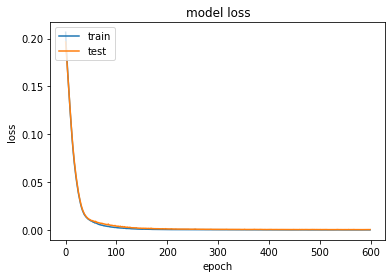

In [22]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## <font color='green'>Training the Algorithm (INF)</font>

In [23]:
x_train_list = bloch_vectors_with_noise[:300]
y_train_list = bloch_vectors_noise_free[:300]

x_train = tf.convert_to_tensor(x_train_list)
y_train = tf.convert_to_tensor(y_train_list)

x_val_list = bloch_vectors_with_noise[500:800]
y_val_list = bloch_vectors_noise_free[500:800]

x_val = tf.convert_to_tensor(x_val_list)
y_val = tf.convert_to_tensor(y_val_list)

x_test_list = bloch_vectors_with_noise[800:]
y_test_list = bloch_vectors_noise_free[800:]

x_test = tf.convert_to_tensor(x_test_list)
y_test = tf.convert_to_tensor(y_test_list)

In [24]:
# Define Model
model = tf.keras.models.Sequential([
  tf.keras.layers.InputLayer(input_shape=(15,)),                                 
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(15),
  tf.keras.layers.Lambda(lambda x:  tf.math.sqrt(3.0) * tf.math.l2_normalize(x, axis=1))
  ])

In [25]:
# Compile model
adam_opt = tf.optimizers.Adam(0.001)
model.compile(optimizer=adam_opt,
              loss=inf)

In [26]:
# Train Model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=50, epochs=600)

Epoch 1/600
6/6 [==============================] - 2s 64ms/step - loss: 0.7771 - val_loss: 0.7217
Epoch 2/600
6/6 [==============================] - 0s 21ms/step - loss: 0.6990 - val_loss: 0.6671
Epoch 3/600
6/6 [==============================] - 0s 19ms/step - loss: 0.6334 - val_loss: 0.5916
Epoch 4/600
6/6 [==============================] - 0s 23ms/step - loss: 0.5350 - val_loss: 0.4685
Epoch 5/600
6/6 [==============================] - 0s 25ms/step - loss: 0.4170 - val_loss: 0.3840
Epoch 6/600
6/6 [==============================] - 0s 21ms/step - loss: 0.3406 - val_loss: 0.3217
Epoch 7/600
6/6 [==============================] - 0s 21ms/step - loss: 0.2804 - val_loss: 0.2701
Epoch 8/600
6/6 [==============================] - 0s 25ms/step - loss: 0.2366 - val_loss: 0.2271
Epoch 9/600
6/6 [==============================] - 0s 24ms/step - loss: 0.2003 - val_loss: 0.1978
Epoch 10/600
6/6 [==============================] - 0s 21ms/step - loss: 0.1721 - val_loss: 0.1722
Epoch 11/600
6/6 [=

Epoch 84/600
6/6 [==============================] - 0s 19ms/step - loss: 0.0048 - val_loss: 0.0106
Epoch 85/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0048 - val_loss: 0.0100
Epoch 86/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0046 - val_loss: 0.0102
Epoch 87/600
6/6 [==============================] - 0s 20ms/step - loss: 0.0046 - val_loss: 0.0101
Epoch 88/600
6/6 [==============================] - 0s 23ms/step - loss: 0.0046 - val_loss: 0.0095
Epoch 89/600
6/6 [==============================] - 0s 22ms/step - loss: 0.0043 - val_loss: 0.0093
Epoch 90/600
6/6 [==============================] - 0s 21ms/step - loss: 0.0043 - val_loss: 0.0093
Epoch 91/600
6/6 [==============================] - 0s 21ms/step - loss: 0.0044 - val_loss: 0.0093
Epoch 92/600
6/6 [==============================] - 0s 22ms/step - loss: 0.0043 - val_loss: 0.0091
Epoch 93/600
6/6 [==============================] - 0s 23ms/step - loss: 0.0041 - val_loss: 0.0091
Epoch 94/6

6/6 [==============================] - 0s 18ms/step - loss: 0.0014 - val_loss: 0.0045
Epoch 167/600
6/6 [==============================] - 0s 22ms/step - loss: 0.0015 - val_loss: 0.0044
Epoch 168/600
6/6 [==============================] - 0s 22ms/step - loss: 0.0014 - val_loss: 0.0043
Epoch 169/600
6/6 [==============================] - 0s 21ms/step - loss: 0.0014 - val_loss: 0.0047
Epoch 170/600
6/6 [==============================] - 0s 19ms/step - loss: 0.0015 - val_loss: 0.0045
Epoch 171/600
6/6 [==============================] - 0s 20ms/step - loss: 0.0015 - val_loss: 0.0044
Epoch 172/600
6/6 [==============================] - 0s 18ms/step - loss: 0.0015 - val_loss: 0.0043
Epoch 173/600
6/6 [==============================] - 0s 19ms/step - loss: 0.0014 - val_loss: 0.0045
Epoch 174/600
6/6 [==============================] - 0s 19ms/step - loss: 0.0014 - val_loss: 0.0041
Epoch 175/600
6/6 [==============================] - 0s 21ms/step - loss: 0.0015 - val_loss: 0.0042
Epoch 176/600


6/6 [==============================] - 0s 19ms/step - loss: 7.4178e-04 - val_loss: 0.0029
Epoch 247/600
6/6 [==============================] - 0s 21ms/step - loss: 7.2498e-04 - val_loss: 0.0029
Epoch 248/600
6/6 [==============================] - 0s 19ms/step - loss: 6.8366e-04 - val_loss: 0.0028
Epoch 249/600
6/6 [==============================] - 0s 18ms/step - loss: 6.8028e-04 - val_loss: 0.0028
Epoch 250/600
6/6 [==============================] - 0s 19ms/step - loss: 6.8333e-04 - val_loss: 0.0028
Epoch 251/600
6/6 [==============================] - 0s 19ms/step - loss: 6.9370e-04 - val_loss: 0.0028
Epoch 252/600
6/6 [==============================] - 0s 19ms/step - loss: 7.3417e-04 - val_loss: 0.0029
Epoch 253/600
6/6 [==============================] - 0s 19ms/step - loss: 7.4734e-04 - val_loss: 0.0028
Epoch 254/600
6/6 [==============================] - 0s 18ms/step - loss: 7.1502e-04 - val_loss: 0.0027
Epoch 255/600
6/6 [==============================] - 0s 18ms/step - loss: 6.91

Epoch 325/600
6/6 [==============================] - 0s 24ms/step - loss: 4.6615e-04 - val_loss: 0.0020
Epoch 326/600
6/6 [==============================] - 0s 22ms/step - loss: 4.4034e-04 - val_loss: 0.0021
Epoch 327/600
6/6 [==============================] - 0s 22ms/step - loss: 4.4078e-04 - val_loss: 0.0021
Epoch 328/600
6/6 [==============================] - 0s 21ms/step - loss: 4.0466e-04 - val_loss: 0.0020
Epoch 329/600
6/6 [==============================] - 0s 24ms/step - loss: 4.1000e-04 - val_loss: 0.0021
Epoch 330/600
6/6 [==============================] - 0s 19ms/step - loss: 4.2647e-04 - val_loss: 0.0020
Epoch 331/600
6/6 [==============================] - 0s 18ms/step - loss: 4.0283e-04 - val_loss: 0.0020
Epoch 332/600
6/6 [==============================] - 0s 23ms/step - loss: 4.1783e-04 - val_loss: 0.0020
Epoch 333/600
6/6 [==============================] - 0s 21ms/step - loss: 4.7733e-04 - val_loss: 0.0022
Epoch 334/600
6/6 [==============================] - 0s 21ms/ste

Epoch 404/600
6/6 [==============================] - 0s 22ms/step - loss: 2.8361e-04 - val_loss: 0.0016
Epoch 405/600
6/6 [==============================] - 0s 19ms/step - loss: 2.8855e-04 - val_loss: 0.0017
Epoch 406/600
6/6 [==============================] - 0s 18ms/step - loss: 3.0519e-04 - val_loss: 0.0016
Epoch 407/600
6/6 [==============================] - 0s 21ms/step - loss: 2.9330e-04 - val_loss: 0.0016
Epoch 408/600
6/6 [==============================] - 0s 21ms/step - loss: 2.6673e-04 - val_loss: 0.0016
Epoch 409/600
6/6 [==============================] - 0s 21ms/step - loss: 2.9760e-04 - val_loss: 0.0016
Epoch 410/600
6/6 [==============================] - 0s 16ms/step - loss: 2.7052e-04 - val_loss: 0.0016
Epoch 411/600
6/6 [==============================] - 0s 18ms/step - loss: 2.7945e-04 - val_loss: 0.0016
Epoch 412/600
6/6 [==============================] - 0s 19ms/step - loss: 2.7808e-04 - val_loss: 0.0016
Epoch 413/600
6/6 [==============================] - 0s 20ms/ste

Epoch 483/600
6/6 [==============================] - 0s 18ms/step - loss: 3.6118e-04 - val_loss: 0.0013
Epoch 484/600
6/6 [==============================] - 0s 18ms/step - loss: 2.7690e-04 - val_loss: 0.0013
Epoch 485/600
6/6 [==============================] - 0s 17ms/step - loss: 2.0234e-04 - val_loss: 0.0014
Epoch 486/600
6/6 [==============================] - 0s 18ms/step - loss: 2.0632e-04 - val_loss: 0.0013
Epoch 487/600
6/6 [==============================] - 0s 18ms/step - loss: 1.9409e-04 - val_loss: 0.0014
Epoch 488/600
6/6 [==============================] - 0s 16ms/step - loss: 2.2536e-04 - val_loss: 0.0013
Epoch 489/600
6/6 [==============================] - 0s 16ms/step - loss: 2.2193e-04 - val_loss: 0.0014
Epoch 490/600
6/6 [==============================] - 0s 18ms/step - loss: 2.3347e-04 - val_loss: 0.0013
Epoch 491/600
6/6 [==============================] - 0s 19ms/step - loss: 2.0058e-04 - val_loss: 0.0014
Epoch 492/600
6/6 [==============================] - 0s 16ms/ste

Epoch 562/600
6/6 [==============================] - 0s 16ms/step - loss: 1.5048e-04 - val_loss: 0.0012
Epoch 563/600
6/6 [==============================] - 0s 19ms/step - loss: 1.5713e-04 - val_loss: 0.0012
Epoch 564/600
6/6 [==============================] - 0s 16ms/step - loss: 1.7909e-04 - val_loss: 0.0012
Epoch 565/600
6/6 [==============================] - 0s 17ms/step - loss: 2.2510e-04 - val_loss: 0.0013
Epoch 566/600
6/6 [==============================] - 0s 18ms/step - loss: 2.0677e-04 - val_loss: 0.0011
Epoch 567/600
6/6 [==============================] - 0s 18ms/step - loss: 1.5407e-04 - val_loss: 0.0011
Epoch 568/600
6/6 [==============================] - 0s 20ms/step - loss: 1.4656e-04 - val_loss: 0.0011
Epoch 569/600
6/6 [==============================] - 0s 18ms/step - loss: 1.7965e-04 - val_loss: 0.0011
Epoch 570/600
6/6 [==============================] - 0s 18ms/step - loss: 1.3786e-04 - val_loss: 0.0011
Epoch 571/600
6/6 [==============================] - 0s 16ms/ste

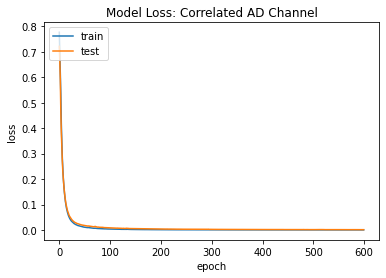

In [27]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Correlated AD Channel')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.xlim(0,30)
plt.show()

In [28]:
score = model.evaluate(x_test,  y_test, verbose=2)

7/7 - 0s - loss: 0.0010 - 257ms/epoch - 37ms/step


In [29]:
#save the model predictions in a tensor
y_prediction = model(x_test)
y_prediction = y_prediction.numpy().tolist()

y_test = tf.cast(y_test, dtype=tf.float32)
x_test = tf.cast(x_test, dtype=tf.float32)


fid = fid_twoq(y_prediction, y_test)

fid_inf = tf.math.reduce_mean(fid)
print(fid_inf)

tf.Tensor((0.9994309-2.2978513e-05j), shape=(), dtype=complex64)
